In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv


<a id='toc'></a>
# **TOC**

1. [1. Import Modules](#1)
2. [2. Import the Data](#2)
3. [3. Dealing with Missing Values](#3)
4. [4. Downsample the Data](#4)
5. [5. Splitting the dataset](#5)
6. [6. One-Hot Encoding](#6)
7. [7. Centering and Scaling the Data](#7)
8. [8. Building a preliminary SVM](#8)
9. [9. Optimize with CrossValidation and GridSearchCV()](#9)
10. [10. Building,Evaluating,Drawing and Interpreting the Final SVM](#10)


<a id='1'></a>
## **1. Import Modules**
[TOC](#toc)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA

<a id='2'></a>
## **2. Import the Data**
[TOC](#toc)


There are 25 variables:

ID: ID of each client <br>
LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit<br>
SEX: Gender (1=male, 2=female)<br>
EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)<br>
MARRIAGE: Marital status (1=married, 2=single, 3=others)<br>
AGE: Age in years<br>
PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, 8=payment delay for eight months, 9=payment delay for nine months and above)<br>
PAY_2: Repayment status in August, 2005 (scale same as above)<br>
PAY_3: Repayment status in July, 2005 (scale same as above)<br>
PAY_4: Repayment status in June, 2005 (scale same as above)<br>
PAY_5: Repayment status in May, 2005 (scale same as above)<br>
PAY_6: Repayment status in April, 2005 (scale same as above)<br>
BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)<br>
BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)<br>
BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)<br>
BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)<br>
BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)<br>
BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)<br>
PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)<br>
PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)<br>
PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)<br>
PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)<br>
PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)<br>
PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)<br>
default.payment.next.month: Default payment (1=yes, 0=no)

In [3]:
df = pd.read_csv("/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
print(f"shape of df: {df.shape} ")
print(f"dimension of df: {df.ndim} ")
print(f"size of df: {df.size} ")

shape of df: (30000, 25) 
dimension of df: 2 
size of df: 750000 


In [5]:
df.rename({'default.payment.next.month': 'Default'}, axis='columns', inplace=True)
df.drop('ID', axis=1, inplace=True)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


<a id='3'></a>
## **3. Dealing with Missing Values**
[TOC](#toc)

In [6]:
df.dtypes

LIMIT_BAL    float64
SEX            int64
EDUCATION      int64
MARRIAGE       int64
AGE            int64
PAY_0          int64
PAY_2          int64
PAY_3          int64
PAY_4          int64
PAY_5          int64
PAY_6          int64
BILL_AMT1    float64
BILL_AMT2    float64
BILL_AMT3    float64
BILL_AMT4    float64
BILL_AMT5    float64
BILL_AMT6    float64
PAY_AMT1     float64
PAY_AMT2     float64
PAY_AMT3     float64
PAY_AMT4     float64
PAY_AMT5     float64
PAY_AMT6     float64
Default        int64
dtype: object

In [7]:
df['SEX'].unique()

array([2, 1])

In [8]:
df['EDUCATION'].unique()

# We see that 5, 6, and 0 are something else
# maybe we should treat 5, 6, 0 as missing values

array([2, 1, 3, 5, 4, 6, 0])

In [9]:
df['MARRIAGE'].unique()

# 0 is also not part of the allowable data, this could be missing value

array([1, 2, 3, 0])

In [10]:
print(len(df.loc[(df["EDUCATION"] == 0) | (df["MARRIAGE"] == 0)]))

"""
we have 68 of the 30,000 rows of missing value. 68/30,000 is less than 1%. 
we can remove the rows with missing values in this case
"""

68


'\nwe have 68 of the 30,000 rows of missing value. 68/30,000 is less than 1%. \nwe can remove the rows with missing values in this case\n'

In [11]:
df_no_missing = df.loc[(df["EDUCATION"] != 0) & (df["MARRIAGE"] != 0)]
df_no_missing.shape

(29932, 24)

In [12]:
print(df_no_missing['EDUCATION'].unique())
print(df_no_missing['MARRIAGE'].unique())
# here we have verified that df_no_missing does not contain any missing values

[2 1 3 5 4 6]
[1 2 3]


<a id='4'></a>
## **4. Downsample the Data**
[TOC](#toc)

SVM are greater with small datasets, so let's downsample for faster performance.

We'll downsample to 1000 of each category (default and no_default)

In [13]:
len(df_no_missing)

29932

In [14]:
df_no_default = df_no_missing[df_no_missing['Default'] == 0]
df_default = df_no_missing[df_no_missing['Default'] == 1]

In [15]:
"""
downsample the dataset in df_no_default
"""
df_no_default_downsampled = resample(df_no_default,
                                    replace=False,
                                    n_samples=1000,
                                    random_state=42)
print((df_no_default_downsampled.shape))
"""
downsample the dataset in df_default
"""
df_default_downsampled = resample(df_default,
                                    replace=False,
                                    n_samples=1000,
                                    random_state=42)
print((df_default_downsampled.shape))

(1000, 24)
(1000, 24)


In [16]:
"""merge the two downsampeld datasets"""
df_downsampled = pd.concat([df_no_default_downsampled, df_default_downsampled])
df_downsampled.shape

(2000, 24)

<a id='5'></a>
## **5. Splitting the dataset**
[TOC](#toc)

In [17]:
X = df_downsampled.drop('Default', axis=1).copy()
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
641,130000.0,2,3,1,28,0,0,0,0,-2,...,50000.0,0.0,0.0,0.0,2500.0,1000.0,0.0,0.0,0.0,0.0
4678,170000.0,1,3,1,29,0,0,0,0,0,...,172307.0,35234.0,32869.0,33862.0,7200.0,7500.0,1200.0,1200.0,1500.0,1300.0
16004,180000.0,2,2,1,29,0,0,0,0,0,...,26310.0,26662.0,26166.0,26176.0,1800.0,1800.0,1500.0,1056.0,950.0,1000.0
22974,210000.0,2,2,2,32,-2,-2,-2,-2,-2,...,410.0,0.0,0.0,0.0,979.0,412.0,0.0,0.0,0.0,0.0
17535,190000.0,2,3,1,45,0,0,0,0,0,...,80548.0,81778.0,83082.0,84811.0,3300.0,3331.0,3359.0,2663.0,2751.0,3000.0


In [18]:
y = df_downsampled['Default'].copy()
y.head()

641      0
4678     0
16004    0
22974    0
17535    0
Name: Default, dtype: int64

<a id='6'></a>
## **6. One-Hot Encoding**
[TOC](#toc)

categorical columns:
1. SEX
2. EDUCATION
3. MARRIAGE
4. PAY_

In [19]:
X_encoded = pd.get_dummies(X, columns=['SEX',
                                       'EDUCATION',
                                       'MARRIAGE',
                                       'PAY_0',
                                       'PAY_2',
                                       'PAY_3',
                                       'PAY_4',
                                       'PAY_5',
                                       'PAY_6'])
X_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,130000.0,28,100143.0,50456.0,50000.0,0.0,0.0,0.0,2500.0,1000.0,...,0,1,0,0,0,0,0,0,0,0
4678,170000.0,29,165027.0,168990.0,172307.0,35234.0,32869.0,33862.0,7200.0,7500.0,...,0,0,0,1,0,0,0,0,0,0
16004,180000.0,29,25781.0,26000.0,26310.0,26662.0,26166.0,26176.0,1800.0,1800.0,...,0,0,0,1,0,0,0,0,0,0
22974,210000.0,32,355.0,975.0,410.0,0.0,0.0,0.0,979.0,412.0,...,0,1,0,0,0,0,0,0,0,0
17535,190000.0,45,76433.0,78472.0,80548.0,81778.0,83082.0,84811.0,3300.0,3331.0,...,0,0,0,1,0,0,0,0,0,0


<a id='7'></a>
## **7. Centering and Scaling the Data**
[TOC](#toc)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, )
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)

(1500, 81) (500, 81)


<a id='8'></a>
## **8. Building a preliminary SVM**
[TOC](#toc)

In [21]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

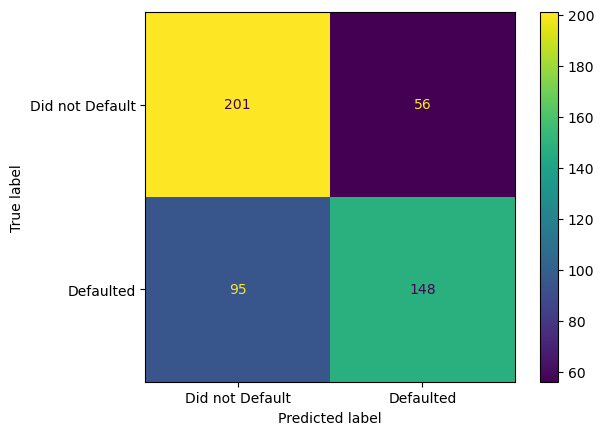

In [22]:
cm = ConfusionMatrixDisplay.from_estimator(clf_svm,
                                           X_test_scaled,
                                           y_test,
                                           values_format='d',
                                           display_labels=['Did not Default', 'Defaulted'])

<a id='9'></a>
## **9. Optimize with CrossValidation and GridSearchCV()**
[TOC](#toc)


We can try to optimize for gamma and C

In [23]:
param_grid = [
    {'C': [0.5, 1, 10, 100], # C must be > 0
     'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
     'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
        SVC(),
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        verbose=0)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


<a id='10'></a>
## **10. Building,Evaluating,Drawing and Interpreting the Final SVM**
[TOC](#toc)


In [24]:
clf_svm = SVC(random_state=42, C=100, gamma=0.001)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.001, random_state=42)

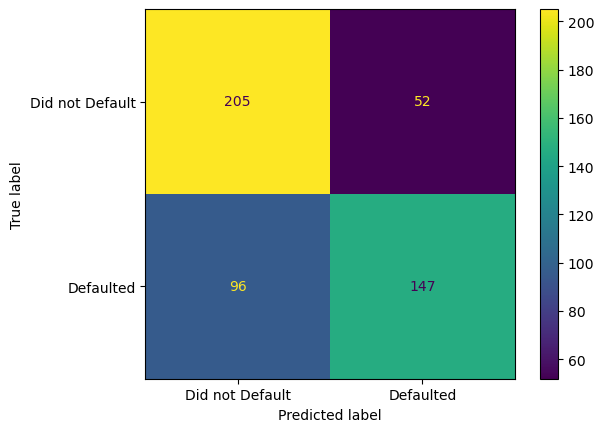

In [25]:
cm = ConfusionMatrixDisplay.from_estimator(clf_svm,
                                           X_test_scaled,
                                           y_test,
                                           values_format='d',
                                           display_labels=['Did not Default', 'Defaulted'])

In [26]:
len(df_downsampled.columns)

24

### Take 24 columns and use PCA to compress them to just 2 columns so we can draw.

Before we do this though, we should plot the scree plot to determine how accurate the shrunken graph will be.

If it's relatively accurate, then it makes sense to draw the 2D graph. If it's not, then the shrunken graph will not be useful. 

(1500, 81)
(1500, 81)


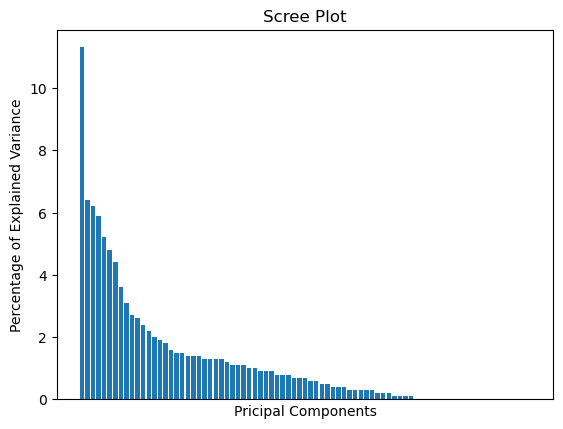

'\nHowever, we only see the FIRST principal component being taller than the rest, but \nthe SECOND principle component is just barely taller than other PCs. \n'

In [27]:
pca = PCA()
print(X_train_scaled.shape)
X_train_pca = pca.fit_transform(X_train_scaled)
print(X_train_pca.shape)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = [str(x) for x in range(1, len(per_var) + 1)]

plt.bar(x=range(1, len(per_var) + 1), height=per_var)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.ylabel("Percentage of Explained Variance")
plt.xlabel('Pricipal Components')
plt.title("Scree Plot")
plt.show()

"""
we want the first two columns of the scree plot to be much taller than the 
rest of the columns, that means those two coulmns would accurately reflect 
the original data.
"""

'''
However, we only see the FIRST principal component being taller than the rest, but 
the SECOND principle component is just barely taller than other PCs. 
'''

In [28]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]

# Note: 
# pc1 contains the x-axis coordinates of the data after PCA
# pc2 contains the y-axis coordinate of the data after PCA

# Now center and scale the PCs
pca_train_scaled = scale(np.column_stack((train_pc1_coords, train_pc2_coords)))
print(pca_train_scaled.shape)

# run GridSearchCV again
param_grid = [
    {'C': [1, 10, 100, 1000],
     'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
     'kernel': ['rbf']}
]

optimal_params = GridSearchCV(
        SVC(),
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        verbose=0)


optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)

(1500, 2)
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


In [29]:
clf_svm = SVC(random_state=42, C=1000, gamma=0.001)
clf_svm.fit(pca_train_scaled, y_train)

SVC(C=1000, gamma=0.001, random_state=42)

In [30]:
# transform the test datasset with PCA
print(X_test_scaled.shape)
X_test_pca = pca.transform(X_test_scaled)
print(X_test_pca.shape)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]

# Note: 
# pc1 contains the x-axis coordinates of the data after PCA
# pc2 contains the y-axis coordinate of the data after PCA

# Now center and scale the PCs
pca_test_scaled = scale(np.column_stack((test_pc1_coords, test_pc2_coords)))
print(pca_test_scaled.shape)

(500, 81)
(500, 81)
(500, 2)


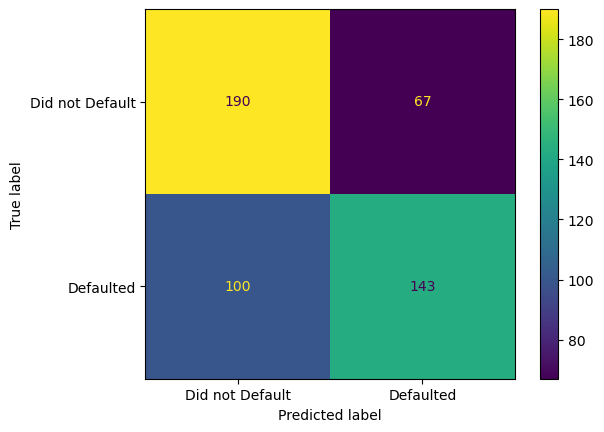

In [31]:
cm = ConfusionMatrixDisplay.from_estimator(clf_svm,
                                           pca_test_scaled,
                                           y_test,
                                           values_format='d',
                                           display_labels=['Did not Default', 'Defaulted'])